# How to make your own benchmark?
This notebook shows an example of how to use the benchmark defition to write a new benchmark class.

Here we make a simple benchmark that creates two circuits, one that prepares all the qubits in the ground state and another one that prepares them in the excited state.

In [1]:
# Define a new benchmark here.
import iqm.benchmarks as qcvv
from iqm.benchmarks import Benchmark
import xarray as xr
from iqm.benchmarks.benchmark_definition import add_counts_to_dataset
from qiskit import QuantumCircuit, transpile
import matplotlib.pyplot as plt

def generate_readout_test_circuit(backend, N_qubits):
    circuits=[]
    qb_to_measure = range(N_qubits)

    qc = QuantumCircuit(N_qubits,N_qubits)
    for qubit in range(N_qubits):
        pass
    qc.barrier()
    qc.measure(qb_to_measure,qb_to_measure)
    circuits.append(qc)

    qc = QuantumCircuit(N_qubits,N_qubits)
    for qubit in range(N_qubits):
        qc.x(qubit)
    qc.barrier()
    qc.measure(qb_to_measure,qb_to_measure)
    circuits.append(qc)
    qc_transpiled = transpile(circuits, backend, optimization_level=0)
    return qc_transpiled


def plot_histogram(
    dataset: xr.Dataset,
):
    fig = plt.figure()
    for ii in range(50):
        try:
            plt.bar(dataset[f"state_{ii}"], dataset[f"counts_{ii}"], label=f"circuit={ii}")
        except:
           break
    plt.xticks(rotation=90)
    plt.legend()
    plt.close()
    return fig


def readout_analysis(run):
    dataset = run.dataset
    plots={}
    plots["histogram"] = plot_histogram(dataset)
    return qcvv.AnalysisResult(dataset=dataset, plots=plots)

class ReadoutTest(Benchmark):
    default_options = dict(N_shots=2048)
    analysis_function = staticmethod(readout_analysis)
    name: str = "readout_test"

    def execute(self, backend)->xr.Dataset:
        """
        Executes the benchmark.
        """
        dataset = xr.Dataset()
        circuits = generate_readout_test_circuit(backend, self.options["N_qubits"])
        job = backend.run(circuits, shots=self.options["N_shots"])
        add_counts_to_dataset(job.result(), dataset)
        return dataset

In [41]:
from iqm.qiskit_iqm import IQMProvider

iqm_server_url ="https://example-station.qc.iqm.fi/cocos/"

benchmark = ReadoutTest(N_qubits=4)
provider = IQMProvider(iqm_server_url)
backend = provider.get_backend()
benchmark.run(backend)

RunResult(dataset=<xarray.Dataset> Size: 480B
Dimensions:   (state_0: 9, state_1: 11)
Coordinates:
  * state_0   (state_0) <U4 144B '0000' '0001' '0010' ... '1000' '1010' '1100'
  * state_1   (state_1) <U4 176B '0011' '0101' '0110' ... '1101' '1110' '1111'
Data variables:
    counts_0  (state_0) int64 72B 1924 26 39 1 20 2 34 1 1
    counts_1  (state_1) int64 88B 2 3 2 72 1 1 48 4 78 36 1801)

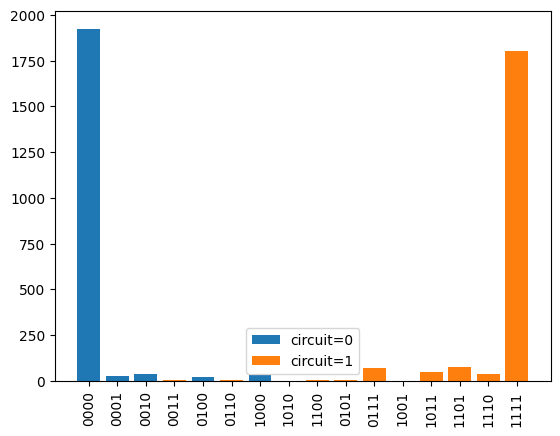

In [42]:
result = benchmark.analyze()
result.plot_all()